<a href="https://colab.research.google.com/github/somilasthana/deeplearningtutorial/blob/master/Details_TensorFlow_Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tf-nightly  # Requires tf 1.13

     |████████████████████████████████| 109.7MB 41.0MB/s 
     |████████████████████████████████| 61kB 26.6MB/s 
     |████████████████████████████████| 491kB 52.4MB/s 
     |████████████████████████████████| 3.1MB 47.9MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


In [0]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd

import tensorflow as tf
tf.set_random_seed(123)

In [0]:
dftrain = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_train.csv')
dfeval  = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_eval.csv')

y_train = dftrain.pop('survived')
y_eval  = dfeval.pop('survived')

In [0]:
fc = tf.feature_column

CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [0]:
def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name, vocab)
  )

In [0]:
feature_columns = []

In [0]:
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

In [0]:
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))

In [0]:
NUM_EXAMPLES = len(y_train)

In [0]:
def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    dataset = ( dataset.repeat(n_epochs).batch(NUM_EXAMPLES))
    return dataset
  return input_fn

In [0]:
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn  = make_input_fn(dfeval, y_eval, n_epochs=1,shuffle=False)

In [0]:
params = {
    
    'n_trees': 50,
    'max_depth': 3,
    'n_batches_per_layer': 1,
    'center_bias': True # The Model uses mean to get predictions initially
    
}

In [0]:
est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
print("Training Initiated...")
est.train(train_input_fn, max_steps=100)
print("Training Complete...")

print("Eval Initiated...")
results = est.evaluate(eval_input_fn)
print("Eval Complete...")


In [0]:
pd.Series(results).to_frame()

,0
accuracy,0.803030
accuracy_baseline,0.625000
auc,0.862504
auc_precision_recall,0.836979
average_loss,0.424687
label/mean,0.375000
loss,0.424687
precision,0.752688
prediction/mean,0.387544
recall,0.707071


**Model Interpretation**

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

In [0]:
pred_dict = list(est.experimental_predict_with_explanations(eval_input_fn))

In [0]:
labels = y_eval.values
probs = pd.Series([ pred['probabilities'][1] for pred in pred_dict ])
df_dfc = pd.DataFrame([ pred['dfc'] for pred in pred_dict ])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
age,264.0,-0.027918,0.075944,-0.138235,-0.076372,-0.051975,0.005251,0.346193
sex,264.0,0.008026,0.105867,-0.094709,-0.072813,-0.071653,0.136930,0.195177
class,264.0,0.018256,0.092379,-0.053097,-0.045918,-0.044858,0.034011,0.232020
deck,264.0,-0.016792,0.028338,-0.068287,-0.041863,-0.025701,0.004882,0.136349
embark_town,264.0,-0.006928,0.026662,-0.052648,-0.014598,-0.013914,-0.002917,0.065829
fare,264.0,0.021081,0.083042,-0.218280,-0.021851,-0.009081,0.043839,0.222620
n_siblings_spouses,264.0,0.003558,0.021372,-0.114192,0.002558,0.002951,0.005208,0.107380
parch,264.0,0.000701,0.004727,-0.049681,0.000288,0.000336,0.000638,0.007157
alone,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [0]:
bias = pred_dict[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
dfc_prob.head()

0    0.130301
1    0.342395
2    0.866757
3    0.798506
4    0.186382
dtype: float64

The larger magnitude contributions have a larger impact on the model's prediction. Negative contributions indicate the feature value for this given example reduced the model's prediction, while positive values contribute an increase in the prediction.

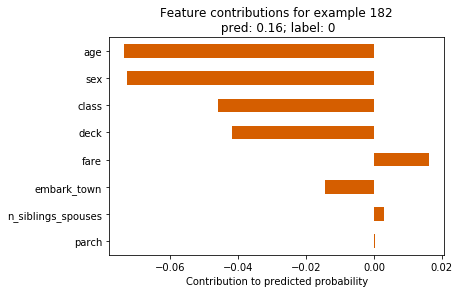

In [0]:
# Plot results.
ID = 182
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = example[sorted_ix].plot(kind='barh', color=sns_colors[3])
ax.grid(False, axis='y')

ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability');

In [0]:
# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)
    
def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
  return ax

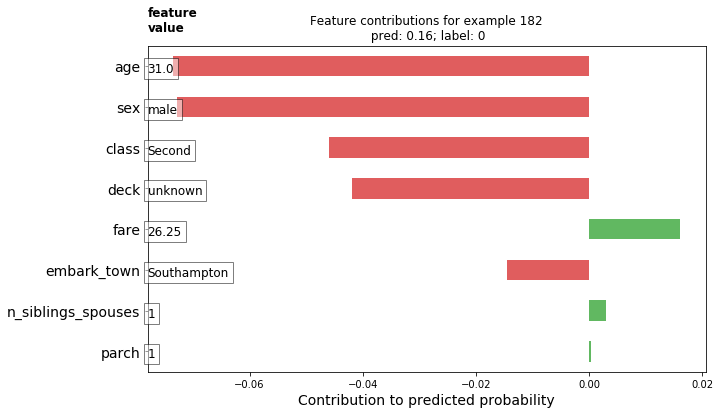

In [0]:
example = df_dfc.iloc[ID]  # Choose IDth example from evaluation set.
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14);

In [0]:
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
  # Initialize plot.
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))
  
  # Create example dataframe.
  TOP_N = 8  # View top 8 features.
  example = df_dfc.iloc[ID]
  ix = example.abs().sort_values()[-TOP_N:].index
  example = example[ix]
  example_df = example.to_frame(name='dfc')
  
  # Add contributions of entire distribution.
  parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
  face_color = sns_colors[0]
  alpha = 0.15
  for pc in parts['bodies']:
      pc.set_facecolor(face_color)
      pc.set_alpha(alpha)
  
  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

  # Add local contributions.
  ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')
  
  # Legend
  # Proxy plot, to show violinplot dist on legend.
  ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
  legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
  legend.get_frame().set_facecolor('white')
  
  # Format plot.
  ax.set_yticks(np.arange(example.shape[0]))
  ax.set_yticklabels(example.index)
  ax.grid(False, axis='y')
  ax.set_xlabel('Contribution to predicted probability', size=14)

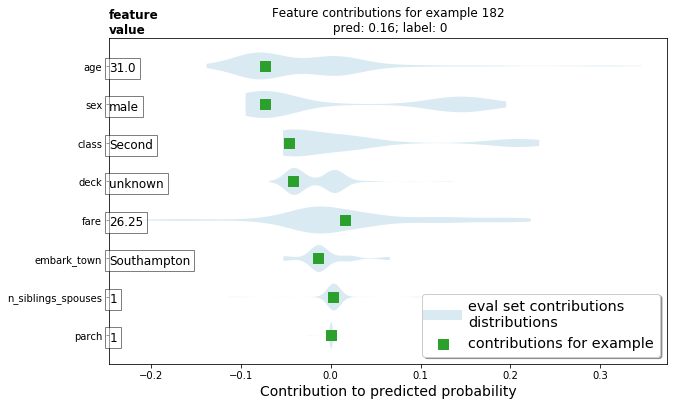

In [0]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]));

Global feature importances



1.   Gain-based feature
2.   Permutation feature
3.   Aggregate DFCs (directional feature contributions)

Gain-based feature importances measure the loss change when splitting on a particular feature, while permutation feature importances are computed by evaluating model performance on the evaluation set by shuffling each feature one-by-one and attributing the change in model performance to the shuffled feature.




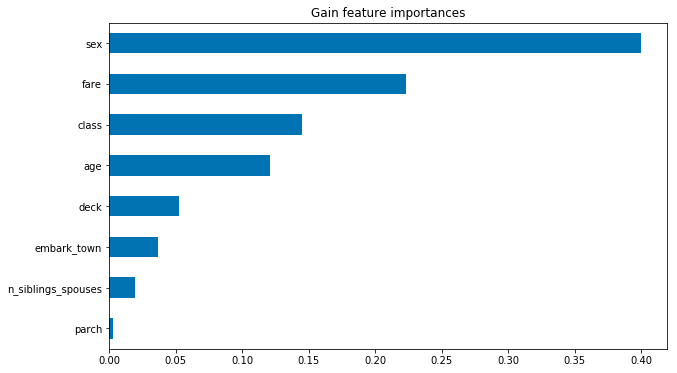

In [0]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')


In [0]:
def permtation_importance(est, X_eval, y_eval, metrics, features):
  baseline = metrics(est, X_eval, y_eval)
  imp = []
  for col in features:
    save = X_eval[col].copy()
    X_eval[col] = np.random.permutation(X_eval[col])
    m = metrics(est, X_eval, y_eval)
    X_eval[col] = save
    imp.append(baseline - m)
  return np.array(imp)

In [0]:
def accuracy_metric(est, X, y):
  eval_input_fn = make_input_fn(X, y, shuffle=False, n_epochs=1)
  return est.evaluate(input_fn=eval_input_fn)['accuracy']

In [0]:
features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS

In [0]:
importance = permtation_importance(est, dfeval, y_eval, accuracy_metric, features)

W0602 22:02:36.529848 139972666607488 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0602 22:02:36.555235 139972666607488 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0602 22:02:38.039557 139972666607488 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0602 22:02:38.066641 139972666607488 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0602 22:02:39.563887 139972666607488 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0602 22:02:39.591678 139972666607488 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0602 22:0

In [0]:
df_imp = pd.Series(importance, index=features)

In [0]:
df_imp.head()

sex                   0.185606
n_siblings_spouses    0.011364
parch                 0.000000
class                 0.053030
deck                 -0.003788
dtype: float32

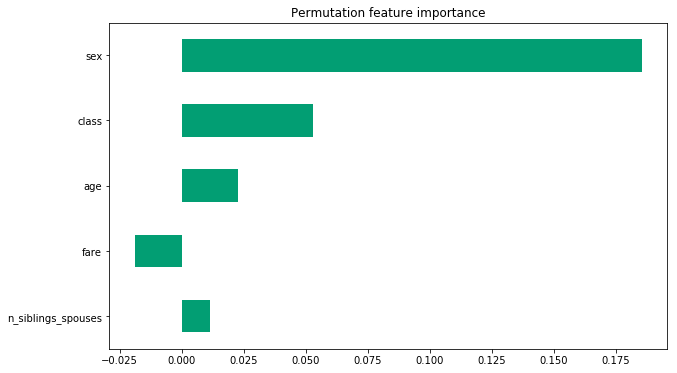

In [0]:
sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance');

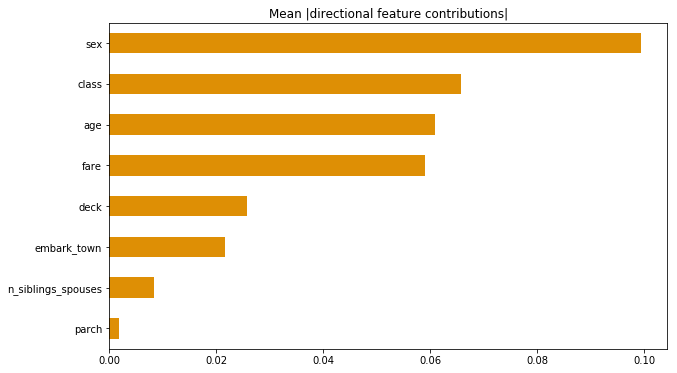

In [38]:
dfc_mean = df_dfc.abs().mean()

N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index
ax = dfc_mean[sorted_ix].plot(
    kind='barh',
    color=sns_colors[1],
    title='Mean |directional feature contributions|',
    figsize=(10, 6))
ax.grid(False, axis='y')

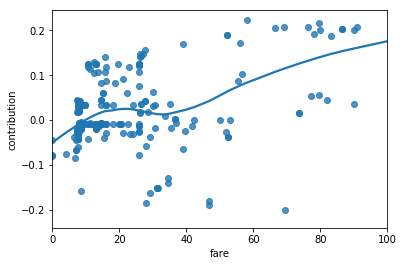

In [39]:
FEATURE = 'fare'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True);
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE);
ax.set_xlim(0, 100);